In [ ]:
# set up code for this experiment
import pandas as pd
import numpy as np
import string
from collections import Counter
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error,mean_squared_error
from datetime import timedelta
import datetime




In [ ]:
# Download the dataset to the server
# Import the data using the read_csv() method from pandas

import urllib.request
import shutil

url = 'https://covidtracking.com/data/download/national-history.csv'
file_name_county='us_data.csv'

with urllib.request.urlopen(url) as response, open(file_name_county, 'wb') as out_file:
    shutil.copyfileobj(response, out_file)

df_us= pd.read_csv(file_name_county)
print(df_us.shape)
df_us.tail()

(310, 18)


,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,recovered,states,totalTestResults,totalTestResultsIncrease
305,2020-01-26,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
306,2020-01-25,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
307,2020-01-24,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,0
308,2020-01-23,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,2,1
309,2020-01-22,NaN,0,NaN,NaN,0,NaN,NaN,0,0,NaN,NaN,0,0,NaN,2,1,0


In [ ]:
# Cleaning Data for null values and reducing feature dimensions
columns=['date', 'states','positive',
       'positiveIncrease', 'negative', 'negativeIncrease','death',  'recovered','deathIncrease', 'inIcuCumulative',
      'hospitalizedIncrease',
       'hospitalizedCumulative','onVentilatorCumulative', 'totalTestResults','totalTestResultsIncrease']

df_us=df_us[columns] #reduced the features where data might be undervalued
print(df_us.shape)

#filtering the samples where data is available for all 56 states and territories 
df_us=df_us[df_us['states']==56]
df_us['date']=pd.to_datetime( df_us['date'])
datetime_idx=pd.DatetimeIndex(df_us['date'])
df_us.set_index(datetime_idx,inplace=True)
df_us=df_us.drop(columns=['date','states'])  # as now all the samples will have same state value


#handling the null values
print(df_us.isnull().sum())
print("----------after replacing----------------")
#replacing the null values with zero because for recovered, ICU and Ventilator data initially were not reported
df_us.fillna(value=0.0,inplace=True)
df_us.index.freq='-1D'
df_us=df_us.iloc[::-1]

print(df_us.isnull().sum())





(306, 15)
positive                     0
positiveIncrease             0
negative                     0
negativeIncrease             0
death                        0
recovered                    9
deathIncrease                0
inIcuCumulative              9
hospitalizedIncrease         0
hospitalizedCumulative       0
onVentilatorCumulative      16
totalTestResults             0
totalTestResultsIncrease     0
dtype: int64
----------after replacing----------------
positive                    0
positiveIncrease            0
negative                    0
negativeIncrease            0
death                       0
recovered                   0
deathIncrease               0
inIcuCumulative             0
hospitalizedIncrease        0
hospitalizedCumulative      0
onVentilatorCumulative      0
totalTestResults            0
totalTestResultsIncrease    0
dtype: int64


In [ ]:
#Graphs 

#positive increse graph


In [ ]:
layout = go.Layout(xaxis=go.layout.XAxis(title = "Date"),
                   yaxis=go.layout.YAxis(title = "Number of Cases"),
                   title = go.layout.Title(text ="Comparing per day Increase"),
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='rgba(0,0,0,0)')
fig= go.Figure(layout=layout)
# fig.add_trace(go.Scatter(x=df_us.index,y=df_us['negativeIncrease'], name='Negative Increase'))

fig.add_trace(go.Scatter(x=df_us.index,y=df_us['negativeIncrease'], name='Negative cases per day'))
fig.add_trace(go.Scatter(x=df_us.index,y=df_us['positiveIncrease'], name='positive cases per day'))
fig.add_trace(go.Scatter(x=df_us.index,y=df_us['totalTestResultsIncrease'], name='Total Tested per day'))



fig.show()

In [ ]:
# Graph
from plotly.subplots import make_subplots
fig= make_subplots(rows=df_us.shape[1],cols=1,subplot_titles=df_us.columns)
i=1
for name in df_us.columns:
  fig.add_trace(go.Scatter(x=df_us.index,y=df_us[name], name=name),row=i,col=1)
  i+=1
  
fig.update_layout(height=4000, width=1200, title_text="Plot for all features")
fig.show()


In [ ]:
# Correlation (feature selection)
# removing correlated features
correlation_mat=df_us.corr() 
fig = go.Figure(data=go.Heatmap(
                    z=correlation_mat,colorscale='Viridis'))
fig.show()
columns = np.full((correlation_mat.shape[0],), True, dtype=bool)
for i in range(correlation_mat.shape[0]):
    for j in range(i+1, correlation_mat.shape[0]):
        if correlation_mat.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = df_us.columns[columns]
df_us=df_us[selected_columns]        # getting the data for only non corelated features
selected_columns

Index(['positive', 'positiveIncrease', 'deathIncrease',
       'hospitalizedIncrease'],
      dtype='object')

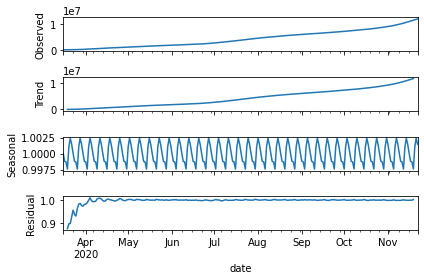

In [ ]:
# decomposing the data into seasonal, trend and residual

from statsmodels.tsa.api import ExponentialSmoothing, VAR
from sklearn.metrics import r2_score
import statsmodels.api as sm
decomp=sm.tsa.seasonal_decompose(df_us['positive'],model='multiplicative')
print()
decomp.plot()
plt.show()



In [ ]:
# confirming time series is not stationary  by Adfuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_us['positive'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' % (key, value))

# ADF statistics is more than significant level 1% value and therefore series in not stationary

ADF Statistic: 2.211786
p-value: 0.998892
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573


In [ ]:
model_evaluation={}
pd.set_option('display.float_format', '{:.2f}'.format)
validation=10
forecast=10
layout = go.Layout(xaxis=go.layout.XAxis(title = "Date"),
                   yaxis=go.layout.YAxis(title = "Number of Cases"),
                   title = go.layout.Title(text ="Exponential Smoothing prediction of 10 Days"),
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='rgba(0,0,0,0)')

#Exponential model

fit2 = ExponentialSmoothing(df_us['positive'][:-validation], trend='mul', seasonal='add' ).fit( smoothing_level=0.8)
pr_df=pd.DataFrame(fit2.forecast(validation+forecast))
print(pr_df[0][validation:])
model_evaluation['Exponential Model']=(mean_absolute_error(df_us['positive'][-validation:], pr_df[0][:validation]),r2_score(df_us['positive'][-validation:], pr_df[0][:validation]),
                                       np.sqrt(mean_squared_error(df_us['positive'][-validation:], pr_df[0][:validation])))

print(f"mean absolute error is {model_evaluation['Exponential Model'][0]}")
print(f" Root mean squared error is {model_evaluation['Exponential Model'][2]}")
print(f"r squared score is {model_evaluation['Exponential Model'][1]}")
fig= go.Figure(layout=layout)
fig.add_trace(go.Scatter(x=df_us.index,y=df_us['positive'], name='actual'))
fig.add_trace(go.Scatter(x=pr_df.index[:validation],y=pr_df[0][:validation],name='validation'))
fig.add_trace(go.Scatter(x=pr_df.index[validation:],y=pr_df[0][validation:],name='forecast'))

fig.show()

2020-11-23   12163096.81
2020-11-24   12329842.43
2020-11-25   12498650.40
2020-11-26   12674341.43
2020-11-27   12855835.97
2020-11-28   13034714.60
2020-11-29   13207773.61
2020-11-30   13379864.99
2020-12-01   13559344.70
2020-12-02   13741020.04
Freq: D, Name: 0, dtype: float64
mean absolute error is 41562.1141542796
mean squared error is 48769.28899682431
r squared score is 0.9895946524800802


In [ ]:
# Vector Auto Regression Model
model = VAR(df_us[['positive','positiveIncrease']][:-validation])
result=model.fit(validation)
pred=result.forecast(result.y,steps=validation+forecast)
pred_y=pd.DataFrame(pred,index=pr_df.index)
print(pred_y[0][validation:])
model_evaluation['VAR']=(mean_absolute_error(df_us['positive'][-validation:], pred_y[0][:validation]),r2_score(df_us['positive'][-validation:], pred_y[0][:validation]),
                         np.sqrt(mean_squared_error(df_us['positive'][-validation:], pred_y[0][:validation])))
print(f"mean absolute error is {model_evaluation['VAR'][0]}")
print(f"r squared score is {model_evaluation['VAR'][1]}")
layout = go.Layout(xaxis=go.layout.XAxis(title = "Date"),
                   yaxis=go.layout.YAxis(title = "Number of Cases"),
                   title = go.layout.Title(text ="VAR validation and prediction for next 10 Days"),
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='rgba(0,0,0,0)')
fig= go.Figure(layout=layout)
fig.add_trace(go.Scatter(x=df_us.index,y=df_us['positive'], name='actual'))
fig.add_trace(go.Scatter(x=pr_df.index[:validation],y=pred_y[0][:validation],name='validation'))
fig.add_trace(go.Scatter(x=pr_df.index[validation:],y=pred_y[0][validation:],name='forecast'))

fig.show()



2020-11-23   12356662.59
2020-11-24   12555071.62
2020-11-25   12767397.51
2020-11-26   12989129.47
2020-11-27   13214515.62
2020-11-28   13438219.14
2020-11-29   13657278.49
2020-11-30   13876025.95
2020-12-01   14103597.88
2020-12-02   14344364.62
Freq: D, Name: 0, dtype: float64
mean absolute error is 27924.57313557323
r squared score is 0.9936689848744132


/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning:

y is a deprecated alias for endog, will be removed in version 0.11.0



In [ ]:
# arima model
from statsmodels.tsa.arima_model import ARIMA
layout = go.Layout(xaxis=go.layout.XAxis(title = "Date"),
                   yaxis=go.layout.YAxis(title = "Number of Cases"),
                   title = go.layout.Title(text ="ARIMA model validation and prediction for next 10 Days"),
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='rgba(0,0,0,0)')
arima = ARIMA(df_us['positive'][:-validation], order=(1, 2, 0))
arima = arima.fit(trend='c', disp=True)
forecast1,ww,cc = arima.forecast(steps= validation+forecast)

model_evaluation['ARIMA']=(mean_absolute_error(df_us['positive'][-validation:],forecast1[:validation]),r2_score(df_us['positive'][-validation:], forecast1[:validation]),
                           np.sqrt(mean_squared_error(df_us['positive'][-validation:], forecast1[:validation])))
print(f"mean absolute error is {model_evaluation['ARIMA'][0]}")
print(f"r squared score is {model_evaluation['ARIMA'][1]}")
predy=pd.DataFrame(forecast1,index=pr_df.index)[0]
print(predy[validation:])
fig= go.Figure(layout=layout)
fig.add_trace(go.Scatter(x=df_us.index,y=df_us['positive'], name='actual'))
fig.add_trace(go.Scatter(x=pr_df.index[:validation],y=predy[:validation],name='validation'))
fig.add_trace(go.Scatter(x=pr_df.index[validation:],y=predy[validation:],name='forecast'))
fig.show()


mean absolute error is 41614.69891589265
r squared score is 0.9876602349612641
2020-11-23   12148467.85
2020-11-24   12309027.83
2020-11-25   12470211.79
2020-11-26   12632019.75
2020-11-27   12794451.69
2020-11-28   12957507.62
2020-11-29   13121187.54
2020-11-30   13285491.45
2020-12-01   13450419.34
2020-12-02   13615971.22
Freq: D, Name: 0, dtype: float64


In [ ]:
data=pd.DataFrame(model_evaluation).T.rename(columns={0:'MAE',2:'RMSE',1:'R2'})
data

,MAE,R2,RMSE
Exponential Model,41562.11,0.99,48769.29
VAR,27924.57,0.99,38041.25
ARIMA,41614.70,0.99,53109.42
